In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

## Supervised learning on mice phenotype data

Predicting diet from differential expression data was easy with SVMs. It was very neat and regular data, no cells were missing, all values were in a similar range, etc. We will now use a slightly uglier dataset: the phenotype tables from days 3/4.

You may remember that each of those sheets had one row per strain, and two separate columns for each measurement taken under the two dietary conditions. We have transformed those sheets such that 1) all of them are contained in a single table, 2) each strain gets two rows, one for phenotype measurements under CD and one for HFD diet. We will use the `diet` column as our target.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [3]:
pheno = pd.read_csv('../example_data/phenotype_cd_hfd.csv', index_col=0)

target = pheno['diet'].replace('CD', 0).replace('HFD', 1)

pheno

,strain,diet,BodyWeight_Wk8_[g],BodyWeight_Wk16_[g],BodyWeight_Wk28_[g],BodyWeight_Sacrifice_[g],BodyWeight_NIBP_[g],BodyWeight_preCLAMS_[g],FatMass_preCLAMS_[g],FatMass_preCLAMS_[%],...,%MONO.Monocyte_[%],%EOS.Eosinophil_[%],%BASO.Basophil_[%],%LUC.LargeUnknownCells_[%],#NEUTR.Neutrophil_[#*10^3/µL],#LYMPH.Lymphocyte_[#*10^3/µL],#MONO.Monocyte_[#*10^3/µL],#EOS.Eosinophil_[#*10^3/µL],#BASO.Basophil_[#*10^3/µL],#LUC.LargeUnknownCells_[#*10^3/µL]
0,BXD1,CD,23.7700,27.9000,30.620000,28.3260,27.340000,27.87600,3.18200,11.364000,...,0.800,0.970,0.070,0.670,0.190000,3.750000,0.030000,0.040000,0.0000,0.030
1,BXD1,HFD,24.3780,35.9980,37.238000,38.8900,36.520000,36.46200,11.59000,31.420000,...,0.930,1.830,0.050,1.380,0.280000,5.470000,0.050000,0.110000,0.0000,0.080
2,BXD100,CD,27.3100,36.1700,41.500000,40.9760,36.600000,36.17667,8.77000,21.836670,...,2.050,2.200,0.150,0.800,0.525000,4.355000,0.105000,0.110000,0.0100,0.070
3,BXD100,HFD,28.5580,45.3200,54.100000,56.9560,50.700000,45.32000,15.25780,33.368000,...,1.550,4.850,0.200,0.800,0.670000,6.845000,0.120000,0.430000,0.0150,0.070
4,BXD101,CD,22.4400,28.5700,32.240000,31.3050,30.210000,28.57000,5.05800,17.570000,...,3.250,1.450,0.050,0.700,0.720000,7.880000,0.290000,0.130000,0.0100,0.070
5,BXD101,HFD,27.2400,43.8200,49.905000,51.8700,45.140000,43.67000,16.48000,37.700000,...,3.680,1.330,0.150,2.180,0.850000,7.850000,0.350000,0.120000,0.0100,0.210
6,BXD11,CD,23.6880,29.5875,35.250000,33.4400,31.740000,29.58750,5.15000,16.240000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,BXD11,HFD,24.6860,46.7480,57.187500,55.5850,46.030000,46.74800,19.15840,39.828995,...,2.550,4.450,0.275,0.325,1.450000,6.350000,0.220000,0.375000,0.0200,0.030
8,BXD12,CD,24.2620,28.6620,30.572000,29.2360,29.244000,28.66200,NaN,NaN,...,1.500,4.650,0.100,2.075,0.350000,3.945000,0.075000,0.220000,0.0000,0.100
9,BXD12,HFD,22.3060,27.6980,34.368000,32.8640,28.926000,27.69800,3.72820,13.350948,...,1.360,6.240,0.220,0.260,0.592000,4.064000,0.072000,0.304000,0.0080,0.016


### 1.1 Get rid of columns with missing values

Since most ML algorithms can't deal with NaN values, we will first restrict ourselves to those features that are available for every sample.
Identify these columns and put `pheno.loc[:, good_columns]` into the variable `data`.

Also, drop the columns `diet` and `strain` from the data table, since we don't want to use them for prediction.

In [4]:
data = pheno.dropna(axis=1)
data_dropped = data.drop(['diet', 'strain'], axis=1)

### 1.2 Use an SVM for your predictions
Try the RBF kernel for a change. First, fit and score using the entire dataset, and print out the accuracy.
Do a proper evaluation using 3-fold cross-validation, and print those scores as well. How did it go?

In [5]:
clf = SVC()
clf.fit(data_dropped, target)

kf = StratifiedKFold(n_splits=3, shuffle=True)
cross_val_score(clf, data_dropped, target, cv=kf).mean()

0.4954954954954955

### 1.3 Use a linear kernel to get the same two values
Was it better or worse than with the RBF? Why?

In [6]:
clf_lin = SVC(random_state=0, kernel='linear', class_weight={0: 0.01, 1: 0.99})

kf = StratifiedKFold(n_splits=3, shuffle=True)
cross_val_score(clf_lin, data_dropped, target, cv=kf).mean()

0.8847795163584639

### 1.4 Standardize the data
Look at the value ranges of each feature. Standardize them, such that they all have zero mean and 1 standard deviation. Either by simply subtracting the means and dividing by the standard deviations, or using the `sklearn.preprocessing.StandardScaler` class.

Display the cross-validated scores using an RBF and a linear SVM.

In [7]:
scaler = StandardScaler()
print(scaler.fit(data_dropped))

scaled = scaler.transform(data_dropped)

# Cross Validated score using linear SVM
# clf_lin.fit(scaled, target)
# cross_val_score(clf_lin, scaled, target, cv=kf).mean()

# # Cross Validated score using RBF Kernel
# clf.fit(scaled, target)
# cross_val_score(clf, scaled, target, cv=kf).mean()

# Standardizing of the values benefits the rbf kernel a lot, the performance improves.
# Standardizing in general is very helpful if the range of the data points is quite high and you have extreme values

StandardScaler(copy=True, with_mean=True, with_std=True)


### 1.4.2 Optional: Standardize the data fold-by-fold

When we standardized the entire dataset in one go, we were cheating a bit. We did not keep the training and test data fully independent. For a truly honest evaluation, we should derive the standardization parameters from the training data only, and apply the same transformation to the test data separately.

If you standardize manually, use the training set means and std's for the transformation of both the training and the test data. If you use `StandardScaler`, use `fit_transform` for the training data and `transform` only for the training data.

Did it influence the accuracy?

SENSITIVITY 1.0
SPECIFICITY 0.7368421052631579


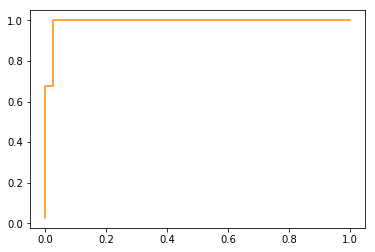

SENSITIVITY 0.9473684210526315
SPECIFICITY 0.6842105263157895


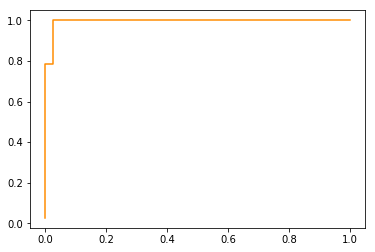

SENSITIVITY 0.8333333333333334
SPECIFICITY 0.9473684210526315


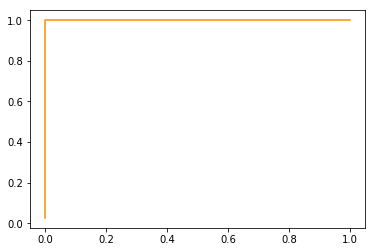

In [8]:
# Do cross validation without standardizing the entire data set
# Plot ROC curver for each fold
kf = StratifiedKFold(n_splits=3, shuffle=True)
for train, test in kf.split(data_dropped, target):
    
    data_train = scaler.fit_transform(data_dropped.iloc[train])
    data_test = scaler.transform(data_dropped.iloc[test])
    target_train = target.iloc[train]
    target_test = target.iloc[test]
    clf_lin.fit(data_train, target_train)

    predictions = clf_lin.predict(data_test)
    matrix = confusion_matrix(target_test, predictions)
    
    tp = matrix[1,1]
    tn = matrix[0,0]
    fp = matrix[0,1]
    fn = matrix[1,0]

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    print('SENSITIVITY', sensitivity)
    print('SPECIFICITY', specificity)
    
    scores = clf_lin.decision_function(data_train)
    
    # calculate all ingridients for the 
    fpr, tpr, thresholds = metrics.roc_curve(target_train, scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot it
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.show()
    


### 1.5: Sensitivity, specificity, precision...
In some cases, the accuracy of a prediction is secondary to other quality measures, such as sensitivity or specificity. For example, HIV tests are optimized for sensitivity at the expense of accuracy, ensuring that very few HIV-positive individuals test negative on an HIV test. This results in an HIV-scare for a lot of HIV-negative individuals each year (as higher sensitivity always implies a higher false positive rate) but in exchange no case of HIV goes undetected on a test.

We can tune most ML models similarly, and sacrifice accuracy for higher sensitivity or specificity. But first, simply report the sensitivity of your linear SVM for both classes. You will find tools in `sklearn` that help you calculate this value.

In [9]:
# See previous task

### 1.5.2 Make your SVM 95+% sensitive for HFD
Find a parameter that helps you increase your sensitivity for mice on an HFD diet.

In [10]:
# Already at 95%

### 1.6 ROC curves
You might be interested in your model's relationship between its accuracy and sensitivity, or a more commonly used pair of quality measures: false positive rate vs. sensitivity (aka true positive rate). This is what ROC (receiver operating characteristic) curves display: the trade-off between these two qualities.

Most classification ML methods, despite their categorical output, use continuous internal variables for their predictions, and their final decision is a simple thresholding of this continuous variable. For example, in the case of SVMs, this variable is the data point's signed distance to the separating plane: positive values are assigned to one class, negative values to the other class. Values close to zero (= close to the boundary) are harder to place in either class, and it's down to the arbitrary threshold how they end up being predicted.

You can create a ROC curve by testing how the choice of threshold affects false positive rate and sensitivity. Needless to say, `sklearn` helps you create such plots. All you need to do is extract the SVM's continuous predictive variables, pass it to the appropriate function with the true labels, and plot the results.

array([ 4.78635939,  1.11561728,  1.00287577,  0.88864884,  0.86978712,
        0.6616068 ,  0.41321316,  0.21757707,  0.06638889,  0.01952999,
       -0.66948196, -0.73043892, -0.98751226, -0.98833482, -2.45623235])

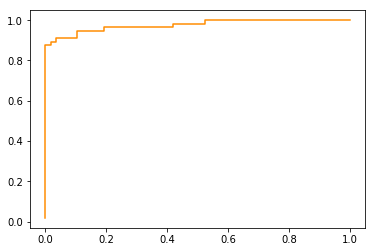

In [12]:
# Scores for roc curve
scores = clf_lin.decision_function(scaled)

# calculate all ingridients for the 
fpr, tpr, thresholds = metrics.roc_curve(target, scores, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot it
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)

thresholds

### 1.7 Find the threshold for the desired sensitivity / FPR tradeoff
In 1.5.2 you increased sensitivity for HFD (label 1) by telling the SVM to use a higher weight for that class. Since then, you have learned that you could have also used the SVM's continuous predictive variables, and threshold them to your own liking, instead of leaving it to the SVM's default (0 for decision_function and 0.5 for predict_proba).

Your task is to find the threshold value that would suit your purpose (i.e. 95% sensitivity). Remember, the roc_curve function returned three vectors: the ROC plot's FPR values, sensitivity values and the threshold that corresponded to them.

Hint: iterate over the sensitivity and threshold values together, and report the first threshold where sensitivity exceeds 0.95. You can iterate over two lists together using Python's zip function.

In [23]:
# Find threshold for desired FPR tradeoff
for sens, thres in zip(tpr, thresholds):
    if sens > 0.95:
        print(thres)
        break

0.019529990999678948
